### imgtofmri: predicting group-average fMRI responses to visual stimuli

In this notebook we introduce **imgtofmri**, a python package that predicts group-average fMRI responses to individual visual frames. We are publicly releasing this package to aid research investigations into how brain responses are driven from individual frames of movies. 


<!-- ###### (Process memory): -->
Neuroscience research has long investigated how humans are able to adeptly process continuous streams of immense perceptual data. Previous research focused on models of working memory that drew analogies from computer systems and described retrieval of memory from 'memory stores', such as those from a harddrive, where past information was thought to be integrated with present input through access to this working memory 'buffer' [[Baddeley 2012](https://doi.org/10.1146/annurev-psych-120710-100422)]. These theories, however, rely on several distinct memory components (mimicking a CPU, RAM, etc.) that have not been identified in the brain, and in fact, the neural regions often identified as the working memory 'buffers' are the same circuits that perform actual perceptual processing [[Buchsbaum, D'Esposito 2008](https://doi.org/10.1162/jocn.2008.20501)]. As a result of these challenges, more recent theories such as [[Hasson et al. 2015](http://dx.doi.org/10.1016/j.tics.2015.04.006)] postulate that the processing of current input should not be considered separate from working memory traces of past information. Instead, the 'hierarchical process memory' framework posits that a brain's response to current input is dependent not only on that sensory input but also on past input, with different sensory regions operating over distinct timescales. These varying timescales, defined empirically through fMRI and ECoG experiments with scrambled perceptual input at varying scales (e.g. shuffling phonemes, words, sentences, paragraphs, etc), explain how lower order sensory regions have shorter temporal receptive windows (TRW) on the order of milliseconds (e.g. to process phonemes), wheras higher order regions have TRWs on the order of seconds to minutes (e.g. to process a long sentence or paragraph) [[Honey, Christopher 2012](https://doi.org/10.1016/j.neuron.2012.08.011)]. In this manner, process memory provides a framework for describing how the brain continuously integrates present perceptual data with recent contextual information over varying timescales. 
<!-- Futhermore, this frame provides a foundation for describing how humans are able to use memories of , or schemas,  -->


<!-- ###### (Event boundary background): -->
This hierarchical process memory framework also extends well to the event segmentation literature, which uses the framework as a foundation for describing how humans use learned contexts and schemas to segment a constant stream of perceptual input into discrete events of varying timescales [[Zacks, Tversky 2001](http://dx.doi.org/10.1037//0033-2909.127.1.3); [Baldassano et al. 2017](https://doi.org/10.1016/j.neuron.2017.06.041)]. Research in this area has shown that these discrete events can be identified from cortical activity patterns and that the timescales of these events varies along a cortical hierarchy, with higher-order brain regions such as the posterior medial cortex showing longer timescales for events than sensory or early-visual regions [[Baldassano et al. 2017](https://doi.org/10.1016/j.neuron.2017.06.041)]. Movies are commonly used for studying this type of naturalistic perception within an fMRI scanner, and a result, research has focused on decoding semantic content from fMRI timecourse responses to natural movies [[Huth et al. 2016](https://doi.org/10.3389/fnsys.2016.00081)] (worth mention of study decoding what movie someone is watching based on HMM fit to events?). However, many questions remain about the timescale of events in these various brain regions, and about the extent to which these timescales can be predicted.

<!-- or predicting which movie someone is watching by just looking at their sequence of voxel-wise event boundaries, when fit to a machine learning model such as a hidden markov model -->


<!-- % have to motivate why f-f predictions are interesting to study -- this is a way to think ab movie responses and tease out current vs. past stimulus. -->
Furthermore, given that neural circuits process both current perceptual information as well as past information, we would like to know what activity, at a given point of time, can be predicted solely based on current perceptual input. If we can better model cortical responses to current stimulus, disentangled from recent or past stimuli, we might better focus our attention to how cortical circuits integrate recent stimulus to process the present, separate from any specific present stimulus. Thus, if we could predict visuocortical responses to single frames of a movie, we could compare this expected stimulus-driven fMRI response to responses from humans actually watching that movie, and then analyze how much of their neural activity can be explained purely based on semantic and visual features of the current stimulus. In this manner, we hope our model can be used to tease apart neural responses to current input from neural responses to previous stimulus or context. 

<!-- - (more on modeling/prediction of events? -- maybe [[Reynolds 2010](https://doi.org/10.1080/15326900701399913)], [[Shin, Dubrow 2020](https://doi.org/10.1111/tops.12505)])

- (anything on animacy/object | big/small | many/few in visual processing hierarchy?) -->


<!-- ###### (DNNs as feature extractors for neural prediction): -->

In recent years, artificial deep neural networks (DNNs) have shown promise in predicting cortical responses in the human visual cortex when trained on real world categorization tasks [[Cichy et al. 2016](https://doi.org/10.1038/srep27755)]. These neural networks learn to extract features (e.g. shapes, textures, eyes) from naturalistic visual data that allow them to accurately classify objects, animals, and scenes in the images they process [[Olah et al. 2017](https://distill.pub/2017/feature-visualization/)]. These networks can also be used to extract predominant features from input that can then be used to predict brain responses along a cortical processing hierarchy, despite these networks never being trained with neural data [[Eickenberg et al. 2017](https://doi.org/10.1016/j.neuroimage.2016.10.001)]. Research has also shown that the hierarchy of layers in a trained DNN can predict along a hierarchy of processing in the brain, where deeper, or higher, layers in a DNN best predict higher levels of cortical processing [[Kell et al. 2018](https://doi.org/10.1016/j.neuron.2018.03.044), [Schrimpf et al. 2020](https://doi.org/10.1101/407007)]. Using DNNs for feature extraction and brain prediction has also been shown with other modalities, such as audio and language data [cite Huth] as well as  cross-modal audiovisual data [[Khosla et al. 2021](https://doi.org/10.1126/sciadv.abe7547)]. Some models, such as some developed by [[Khosla et al. 2021](https://doi.org/10.1126/sciadv.abe7547)], use recurrences in their networks to better model the temporal integration of current information with recent information. Instead, we are not as interested here in modeling the temporal integration of present and past stimuli, but instead are interested in modeling only the responses to present input, so that we may better focus on the event dynamics in neural responses disentangled from specific stimuli. As a result, we focus on predicting neural responses to single image frames, and then use the resulting event dynamics from our frame-by-frame predicted brains as comparison to temporally integrated human responses to the same films. We also present a comparison of our model with a baseline luminance model, which describes the changes in lighting in image frames of the movie, to understand how the event dynamics of our predicted brains compares to event dynamics suggested purely based on changes in luminance throughout the movie.


<!-- ###### (Model introduction): -->
In this notebook, we present imgtofmri, a python package and model that allows for quick prediction of group-averaged cortical responses to visual stimuli. The model is built by combining a pretrained ResNet-18 DNN with a linear regression model to predict fMRI responses to individual images. The model is trained using data from the open source BOLD5000 project [[Chang et al. 2019](https://doi.org/10.1038/s41597-019-0052-3)], which provides us with the fMRI responses of three subjects viewing 4916 unique and scrambled images. To train this model, we processed the 4916 images through our DNN to extract semantic features, and use these resulting features/activations to predict each subject's fMRI response to that image. In particular, we predict into three visuocortical regions of interest (ROIs) in each subject's brain: the lateral occipital complex (LOC), which is commonly associated with object recognition, the retrosplenial cortex (RSC), and the parahippocampal place area (PPA), which are both cortical regions involved in scene processing. For more information on the training of our model using the open source BOLD5000 dataset and pretrained pytorch ResNet-18 model as our DNN, we have included a notebook within our 'model_training' folder that outlines this process and allows for extensions to other feature-detecting models.

<!--  Model diagram here -->


As we outline in this notebook, we can use this model to predict brain responses to unseen images, or to continuous, naturalistic stimuli such as movies. We validate our model on an unseen dataset, twinset [[Mohsenzadeh, 2019](https://doi.org/10.3390/vision3010008)], and compare our model's predicted fMRI responses to real fMRI responses at a group level, across various categories of visual stimulus, and also within subjects. After validating our model with this novel dataset, we then show how our model can be used to predict continuous fMRI responses to Pixar Animation Studio's Partly Cloudy and compare our model's frame-by-frame predictions to that of human subjects watching the same movie [[Richardson, 2018](https://doi.org/10.1038/s41467-018-03399-2)], showing that much of the event segmentation observed in the human brain can be explained by mid-level semantic information in the visual stimulus.

## Model validation
We first show how we can use imgtofmri to predict fMRI responses to out-of-dataset images. We perform this on the [Twinset Dataset](http://twinsetfusion.csail.mit.edu/) compiled by Mohsenzadeh et al. This dataset is comprised of fMRI data for 15 adults viewing 156 images. These images can also be segmented into five categories: Scenes, Objects, Animals, Bodies, Faces

<center>
<img src="img/twinset_cropped.png" alt="drawing" width="300" align="center"/>
</center>

In [1]:
%load_ext autoreload
%autoreload 2
import imgtofmri

220426-00:13:33,973 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.5.1


First, we download our validation dataset and define the directory to predict from:

In [55]:
stimuli_url = 'http://wednesday.csail.mit.edu/fusion_rep/stimulus/156ImageStimuliSet.zip'
filename = wget.download(stimuli_url)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('input_images')

As mentioned, we are able to predict into five ROIs (EarlyVis, OPA, LOC, PPA, RSC), but by default predict only into LOC, PPA, and RSC, as these three performed strongest above chance on our BOLD5000 train/test split.

Here we define our input directory of images, and output directory to predict into:

In [56]:
input_dir = 'input_images/156ImageStimuliSet/'
output_dir = 'twinset_output/'

rois = ['LOC', 'PPA', 'RSC']

The `predict` function from imgtofmri is the main function of this package and takes in the input directory, output directory, and optionally ROIs to then produce a group-averaged fMRI brain for each image input. The function performs the following steps for every image in the input directory:
<ol> 
    <li> Pushes the image through our pretrained DNN and extracts its activations/features </li>
    <li> Predicts fMRI activity in each BOLD5000 subject's brain from those activations/features </li>
    <li> Transforms that subject's predicted brain into the MNI shared brain space </li>
    <li> Smooths the brain as a basic preprocessing step </li>
    <li> Averages the three predicted brains to form the group-averaged prediction</li>
</ol> 

The model then saves the brain volume for each image in the output directory using the same filename as each image file, with MRI file extension `.nii.gz`.

In [57]:
imgtofmri.predict(input_dir, output_dir, rois)

Averaging MNI brains: 100%|██████████| 157/157 [00:12<00:00, 12.44it/s]


### Twinset Analyses

First, we download the ground truth data from the twinset dataset, which we have lightly preprocessed by resampling each brain to MNI space, extracting our three [note: confirm three vs. five?] ROIs of interest, and smoothing those responses with a sigma=1. This folder includes each subject's fMRI response to each of the 156 images as well as the average responses of all 15 individuals to those same images.

In [67]:
# Code for downloading ground_truth twinset stuff

To evaluate our model's performance on a novel dataset, we compare our predicted fMRI responses to fMRI responses from human subjects, and evaulate the significance of our predictions against a null or chance distribution modeled using permutations. We construct our null distributions by taking the correlation matrix between our predicted and our actual, or 'true', human brains, and performing a number of shuffled permutations. We do this by shuffling the rows of the correlation matrix, and evaluating the difference between the mean of the diagonal and the mean of the off-diagonal. This is a proxy for evaluating how well our predicted brain of a specific image lines up to the actual brain of that specific image, and thus models the null distribution by seeing how many times a randomly permuted correlation matrix might produce a better correlation between the predicted and true brains.


In this manner, if our predictions are strong and well above chance, we expect that the difference between the diagonal and off-diagonal of our correlation matrix will be significantly higher when the matrix is properly aligned, with the predicted brains aligned with actual brains from the same image, as opposed to when we correlate our predicted brains with actual brains from a different image in the dataset. 

To perform this analysis, we first generate correlations between all pairs of predicted and actual brains (156 x 156), which will then be used in the shuffled correlation matrices in constructing our null distribution.

#### Group level analysis

In [6]:
imgtofmri.twinset_generate_group_correlations(output_dir)

Generating correlations with group-averaged brains: 100%|██████████| 156/156 [06:50<00:00,  2.63s/it]


We then perform the actual permutations:

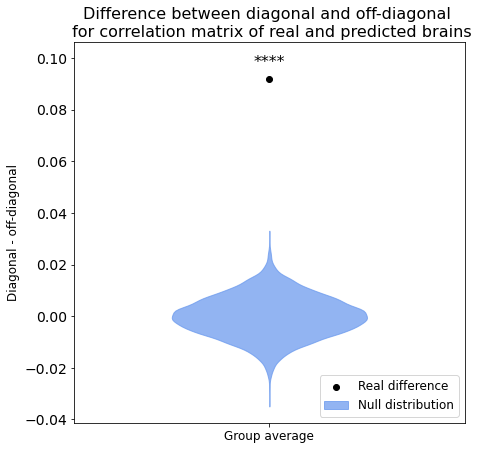

In [58]:
imgtofmri.twinset_random_group_permutations(n_shuffle=10000)

Here we perform this analysis comparing our 156 predicted brains to the actual 156 brains viewing the same set of images, with each of those brains averaged in MNI space across the group of 15 individuals. We see that the difference between the diagonal and off-diagonal in our properly aligned matrix of predicted to real brains is significantly higher than the difference in the shuffled matrices in our null distribution. p-values are calculated here as (the number of shuffled differences greater than the real difference + 1) divided by (the number of resamples + 1).

Throughout this notebook, we use the following convention for significance indicators:
- † = <0.075
- \* = p < 0.05
- \** = p < 0.01
- \*** = p < 0.001, etc.

#### Category level analysis

Next, we perform the same analysis however consider each image as a part of one of the five twinset categories: animals, objects, scenes, people, or faces. In this manner, we can better understand how well our model predicts the fMRI responses to specific categories of visual stimulus. In this analysis, we still average each real or actual brain across all 15 subjects and correlate this averaged brain with all predicted brains to images within the same category.

We first generate all correlations within each category:

In [8]:
imgtofmri.twinset_generate_category_correlations(output_dir)

Generating correlations for 'faces': 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


And subsequently permute null distributions through the same shuffling mechanism as previously explained:

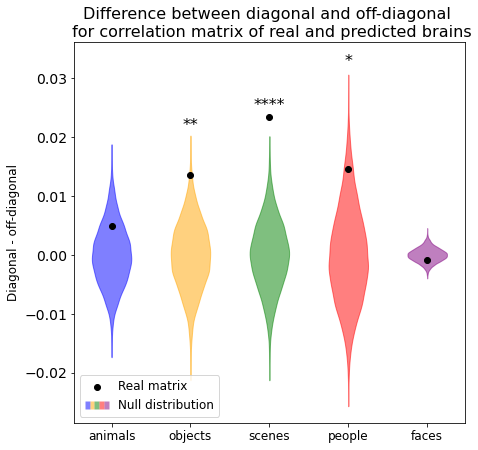

In [66]:
imgtofmri.twinset_random_category_permutations(n_shuffle=10000)

From these results, we see that our predicted brains perform above chance in three of the five categories: objects, scenes, and people. We argue that our model performs strongest in these categories because they have the largest overlap with the BOLD5000 dataset used to train our model, which pulls its images from three computer vision datasets -- Scene UNderstanding (SUN)[cite], Common Objects in Context (COCO)[cite], and ImageNet [cite]. These images were chosen by the BOLD5000 authors to "cover the following image domains: real-world indoor and outdoor scenes; objects interacting in complex, real-world scenes; and objects centered in real-world scenes," so we find the high significance in the scene category to be validation of our model and its training set.

Additionally, we note that our model seems to not predict well into the animal and faces categories -- we argue that this is due to a lack of differentiation between images within these categories that our model can pick up. With faces in particular, we note that our DNN feature extractor was not trained on differentiating faces in any manner, and that we do not specifically predict into the fusiform face area (FFA)[note: should we check if LOC includes this area?], a cortical area heavily associated with face recognition and discrimination.

#### Participant level analysis

Our final validation analysis with the Twinset dataset investigates our model's prediction capabilities to each participant. Here we consider all 156 images per subject, and compare our predicted fMRI response to each subject's actual fMRI response.

We, again, first generate the participant correlations and then calculate the permutations:

In [10]:
# Note, this analysis may take a couple of hours if running from scratch
imgtofmri.twinset_generate_participant_correlations(output_dir)

Generating correlations per participant: 100%|██████████| 2340/2340 [2:35:17<00:00,  3.98s/it]  


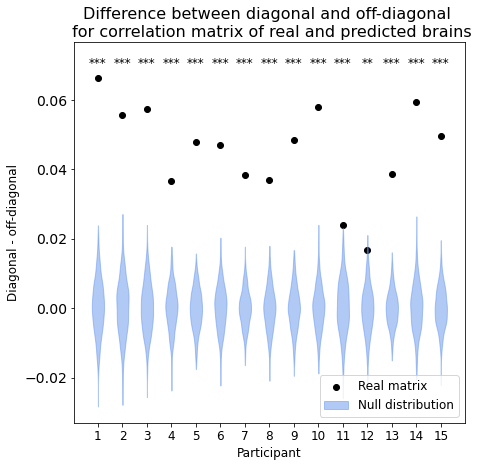

In [68]:
imgtofmri.twinset_random_participant_permutations(n_shuffle=1000)

Here, we see that our model has predictive power within each subject as well, with the diagonal - off-diagonal difference in the un-permuted matrix significantly higher than the null distribution within all subjects.

## Extending our model to movies

In this final section, we extend our image prediction model to process movies, and compare our model to a baseline luminance model.

In [12]:
from imgtofmri import *
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# TODO: provide link for download? copyright?

In [14]:
input_dir = 'partly_cloudy_frames'
output_dir = 'output_partly_cloudy'

In [13]:
# ! mkdir partly_cloudy_frames
utils.extractImages('PartlyCloudy.m4v', 'partly_cloudy_frames/')

Saving movie frames: 691it [03:04,  3.75it/s]                         


In [15]:
imgtofmri.predict(input_dir, output_dir)

Averaging MNI brains: 100%|██████████| 691/691 [00:47<00:00, 14.54it/s]


In [ ]:
# load movie code here

In [16]:
# preprocessing steps happened here: 
# load predicted brain
# convolve w hrf, downsample, removing average activity, remove DCT
# saved as pred_processed.nii.gz
# (probably should add the TR trimming of [2:-8] to take out credits)

In [17]:
true_dir = "ground_truth/partly_cloudy/"
output_dir = "output/"
input_dir = "partly_cloudy_frames/"
overlap = get_subj_overlap()

In [45]:
# Loading True brains
true = nib.load(f'{true_dir}/avg_r_ro_m_s_z_ra_dcto.nii.gz').get_fdata()
true = true[:,:,:,10:]
true = np.corrcoef(true[overlap].T)

In [19]:
# Loading predicted brains
pred = nib.load('pred_processed.nii.gz').get_fdata()
pred = pred[:,:,:,2:-8]
pred = np.corrcoef(pred[overlap].T)

In [20]:
# Loading Luminance model as comparison
lum = get_luminance(input_dir=input_dir)
lum = np.corrcoef(lum)

Downsampling: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Text(0.5, 0.98, 'Correlation matrices for Partly Cloudy')

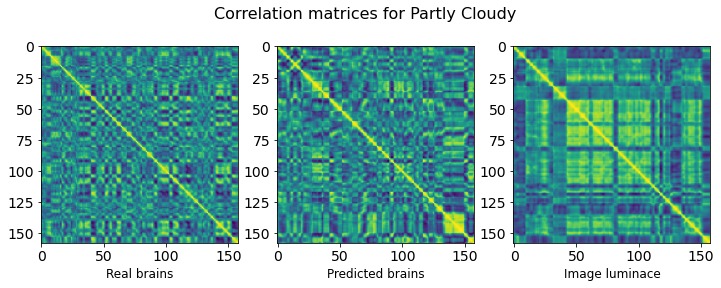

In [46]:
# Correlation matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].imshow(true)
axes[1].imshow(pred)
axes[2].imshow(lum)
axes[0].set_xlabel('Real brains', fontsize=12)
axes[1].set_xlabel('Predicted brains', fontsize=12)
axes[2].set_xlabel('Image luminace', fontsize=12)
fig.suptitle('Correlation matrices for Partly Cloudy', fontsize=16)

### Comparing performance between Predicted brains + Luminance model

In [34]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=None)

Generating and loading bootstraps: 100%|██████████| 100/100 [05:54<00:00,  3.55s/it]


#### On the full movie timecourse

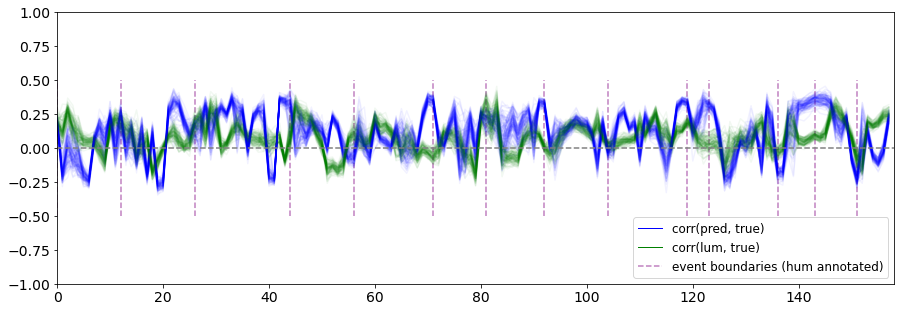

In [35]:
pc_pred_lum_timecourse(corr)

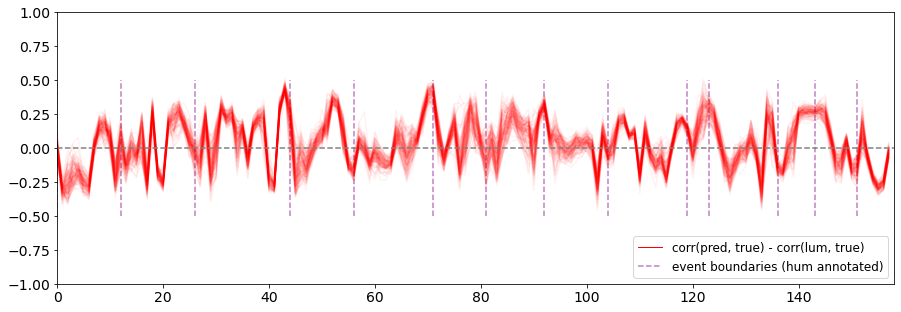

In [36]:
pc_difference_timecourse(corr)

#### Boundary triggered averages with bootstraps

In [37]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:10<00:00, 92.17it/s]


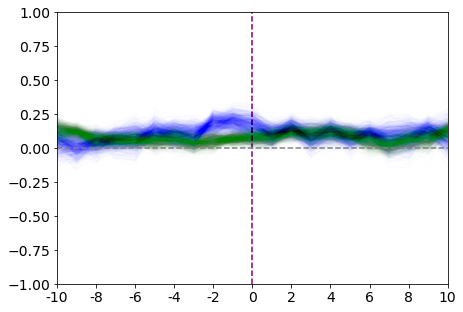

In [38]:
pc_bootstrapped_pred_lum(bound_averages)

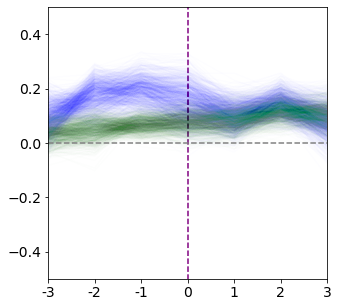

In [39]:
pc_bootstrapped_pred_lum_3TRs(bound_averages)

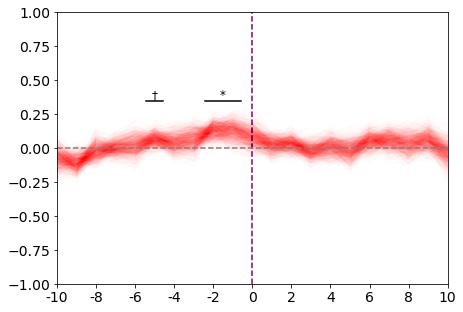

In [40]:
pc_bootstrapped_difference(bound_averages)

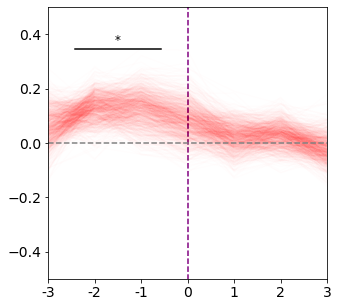

In [41]:
pc_bootstrapped_difference_3TRs(bound_averages)